Define the base cosmology, which is the Planck 2018 cosmology. 

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from astropy.cosmology import Planck18 as planck
import camb
from camb import model
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pickle

# import colossus for HMF definition 
from colossus.cosmology import cosmology as cc
from colossus.lss import mass_function

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


### Define baseline cosmology for `camb` $P_{\rm lin} (k)$ and the `colossus` HMF. 

In [3]:
pars = camb.set_params(H0=planck.H0.value, 
                       ombh2=planck.Ob0 * planck.h**2, 
                       omch2=planck.Odm0 * planck.h**2, 
                       mnu=planck.m_nu.value[-1], 
                       num_nu_massive = (planck.m_nu.value > 0).sum(),
                       omk=planck.Ok0, 
                       tau=0.0543, As=np.exp(3.0448)/10**10, ns=0.96605, #Plik best fit Planck 2018 Table 1 left-most col 1807.06209
                       halofit_version='mead', lmax=2000)

In [4]:
colossus_planck_cosmo = cc.fromAstropy(astropy_cosmo = planck, 
                      sigma8 = 0.809, # based on CAMB using the As 
                      ns = 0.96605, 
                      cosmo_name = 'planck_baseline')

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/colossus/cosmology/cosmology.py:3338: UserWarning: Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.
  warnings.warn('Astropy cosmology class contains massive neutrinos, which are not taken into account in Colossus.')


In [5]:
# set halo mass bins

# range from 10e7 to 10e15 to cover almost all CIB galaxies 
Mh = np.logspace(7, 15, 50)

In [102]:
import pandas as pd

In [103]:
# read in ELG dndz 
dndz = pd.read_csv("data/gal/elg_fuji_pz_single_tomo.csv")
z = dndz['Redshift_mid'].values
z_with_0 = np.zeros(len(z) + 1)
z_with_0[1:] = z

## Preprocess for ELGs

### Calculate $P_{\rm lin} (k)$

In [23]:
pars.set_matter_power(redshifts = z_with_0, kmax=10.0)

Note: redshifts have been re-sorted (earliest first)


class: <CAMBparams>
 WantCls = True
 WantTransfer = True
 WantScalars = True
 WantTensors = False
 WantVectors = False
 WantDerivedParameters = True
 Want_cl_2D_array = True
 Want_CMB = True
 Want_CMB_lensing = True
 DoLensing = True
 NonLinear = NonLinear_none
 Transfer: <TransferParams>
   high_precision = True
   accurate_massive_neutrinos = False
   kmax = 10.0
   k_per_logint = 0
   PK_num_redshifts = 31
   PK_redshifts = [2.950000000000001, 2.8500000000000014, 2.750000000000001, 2.650000000000001, 2.5500000000000007, 2.450000000000001, 2.3500000000000005, ...]
 want_zstar = False
 want_zdrag = False
 min_l = 2
 max_l = 2150
 max_l_tensor = 600
 max_eta_k = 5375.0
 max_eta_k_tensor = 1200.0
 ombh2 = 0.0224178568132
 omch2 = 0.11934063901639999
 omk = 0.0
 omnuh2 = 0.000644866570625114
 H0 = 67.66
 TCMB = 2.7255
 YHe = 0.2458759299699272
 num_nu_massless = 2.0293333333333337
 num_nu_massive = 1
 nu_mass_eigenstates = 1
 share_delta_neff = False
 nu_mass_degeneracies = [1.0146666666

In [24]:
#Linear spectra
pars.NonLinear = model.NonLinear_none
results = camb.get_results(pars)
kh, z, pk = results.get_matter_power_spectrum(minkh=1e-4, maxkh=3, 
                                              npoints = 400) #FIXME this is in units of little h

In [26]:
results.get_sigma8_0()

0.8093107469735158

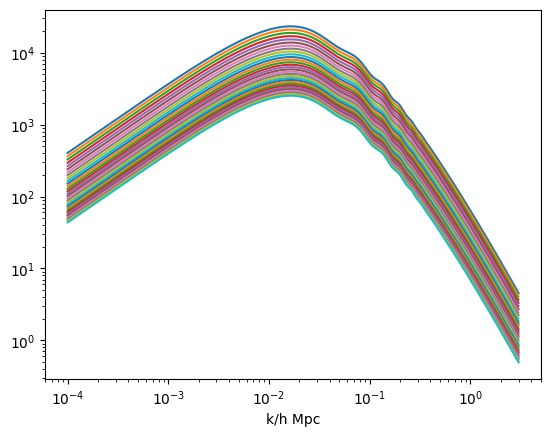

In [51]:
for i in range(len(z)):
    plt.loglog(kh, pk[i,:])
plt.xlabel('k/h Mpc');
#plt.legend(['linear','non-linear'], loc='lower left');
#plt.title('Matter power at z=%s and z= %s'%tuple(z));

In [29]:
# dictionary to store with relevant information 
plin_dict = {}

plin_dict['z'] = z
plin_dict['kh'] = kh
plin_dict['pk'] = pk

In [30]:
with open('data/plin_unit_h.p', 'wb') as handle:
    pickle.dump(plin_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Calculate HMF (z)

In [7]:
from colossus.lss import mass_function

In [8]:
cc.setCurrent(colossus_planck_cosmo) # set cosmology defn

hmfz = np.zeros((len(z), len(Mh))) #HMF of shape (z, Mh)

for i in range(len(z)):
    hmfz[i] = mass_function.massFunction(x = Mh,
                           z = z[i],
                           mdef = '200m',
                           model = 'tinker08',
                           q_in = 'M',
                           q_out = 'dndlnM')

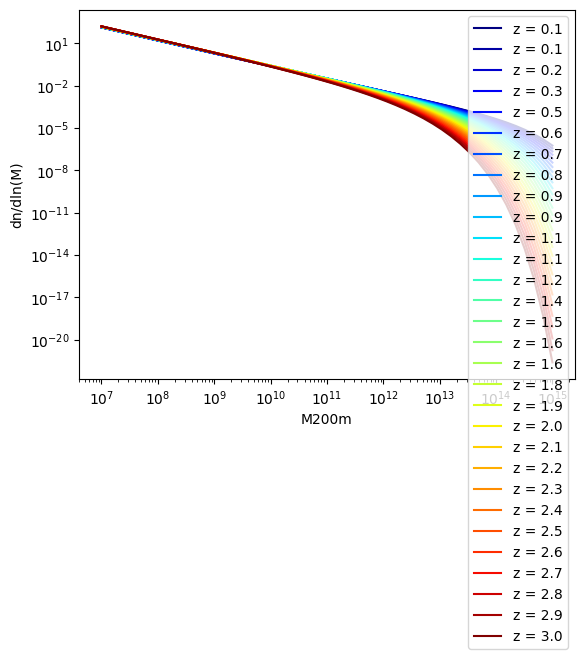

In [10]:
plt.xlabel('M200m')
plt.ylabel('dn/dln(M)')

colors = plt.cm.jet(np.linspace(0,1,len(z)))
for i in range(len(z)):
    plt.loglog(Mh, hmfz[i], '-', label = 'z = %.1f' % (z[i]),
             color = colors[i])
plt.legend();

In [29]:
# save hmf dictionary information
hmfz_dict = {}
hmfz_dict['z'] = z
hmfz_dict['Mh'] = Mh
hmfz_dict['hmfz'] = hmfz

In [31]:
with open('data/hmfz.p', 'wb') as handle:
    pickle.dump(hmfz_dict, handle, protocol=pickle.HIGHEST_PROTOCOL)

### Test codes

### consts.py

In [1]:
from astropy.cosmology import Planck18 as planck
import astropy.cosmology.units as cu
import astropy.units as u

In [2]:
import numpy as np

In [3]:
strfig = "allcomponents_lognormal_sigevol_1p5zcutoff_nolens_onlyautoshotpar_no3000_gaussian600n857n1200_planck_spire_hmflog10.txt"
cibres = "data/one_halo_bestfit_"+strfig

In [4]:
sar = np.loadtxt(cibres)[4:8, 0]  # 217, 353, 545, 857

In [8]:
freq = np.array([100., 143., 217., 353., 545., 857.])

In [9]:
nfreq = len(freq)

In [10]:
ell = np.arange(100, 2000)
nl = len(ell)
nl

1900

In [11]:
shotcib = np.zeros((nfreq, nl))
shotcib.shape

(6, 1900)

In [13]:
sa = np.array([1.3*0.116689509208305475, 1.3*0.8714424869942087, 14., 357., 2349., 7407.])
sa[2:] = sar

In [15]:
for i in range(nfreq):
    shotcib[i,:] = sa[i]

In [17]:
r_l = 1.0 # FIXME: line 333 of run_driver ?
shotgal = 4.618165243131944e-08*np.ones_like(ell)
crossshot = r_l*np.sqrt(shotcib*shotgal)

In [21]:
import matplotlib.pyplot as plt

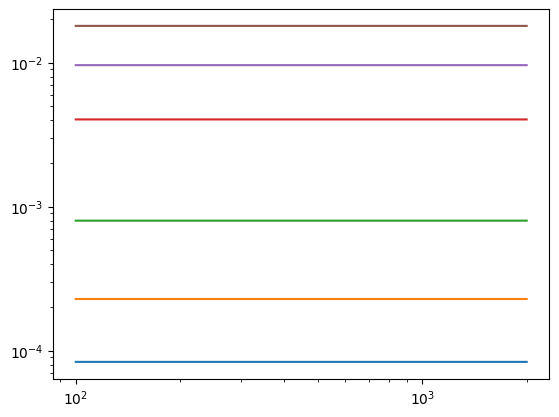

In [22]:
for i in range(6):
    plt.loglog(ell, crossshot[i])

In [138]:
tmpM = 100 * u.Msun * cu.littleh**-1
tmpM

<Quantity 100. solMass / littleh>

In [139]:
tmpM.to(u.Msun, cu.with_H0(planck.H0))

<Quantity 147.79781259 solMass>

In [141]:
tmpM2 = 100 * u.Msun
tmpM2

<Quantity 100. solMass>

In [142]:
tmpM2.to(u.Msun * cu.littleh**-1, cu.with_H0(planck.H0))

<Quantity 67.66 solMass / littleh>

In [146]:
mean_density0 = (planck.Om0*planck.critical_density0).to(u.Msun/u.Mpc**3)
mean_density0

<Quantity 3.93431748e+10 solMass / Mpc3>

In [149]:
mean_density0.to((u.Msun * cu.littleh**-1)/(u.Mpc * cu.littleh)**3,
                 cu.with_H0(planck.H0))

<Quantity 8.24512751e+09 solMass / (littleh4 Mpc3)>

In [153]:
tmpvol = 1 * (u.Mpc * cu.littleh**-1)**3
tmpvol

<Quantity 1. Mpc3 / littleh3>

In [155]:
density = 1/tmpvol

In [156]:
density.to(u.Mpc**(-3), cu.with_H0(planck.H0))

<Quantity 0.30973906 1 / Mpc3>

In [157]:
density

<Quantity 1. littleh3 / Mpc3>

In [158]:
1 * planck.h**3

0.30973906309599997

In [140]:
100/planck.h

147.79781259237365

In [136]:
0.49 * planck.h

0.331534

In [129]:
cu.littleh

Unit("littleh")

In [126]:
planck.H0

<Quantity 67.66 km / (Mpc s)>

In [127]:
planck.h

0.6766

In [80]:
import pickle

In [81]:
with open('data/gal/dndz_extended.p', 'rb') as handle:
    dndz = pickle.load(handle)

In [88]:
with open('data/plin_unit_h.p', 'rb') as handle:
    Plin = pickle.load(handle)

In [83]:
Plin.keys()

dict_keys(['z', 'kh', 'pkh'])

In [84]:
dndz['dndz'].mean(axis = 0)

array([0.0301039 , 0.1185164 , 0.09135664, 0.05454295, 0.04795344,
       0.0347682 , 0.13196637, 0.65681441, 1.32650456, 1.55739618,
       1.23017891, 1.0662644 , 0.95300988, 0.82665647, 0.65179378,
       0.42128632, 0.20873498, 0.1293551 , 0.08514541, 0.05797201,
       0.0403514 , 0.0285305 , 0.02041203, 0.01473959, 0.01072362,
       0.00785054, 0.00577756, 0.00427125, 0.00317014, 0.0023611 ])

In [85]:
dndz['zrange']

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95])

In [89]:
Plin['z']

array([ 0.  ,  0.05,  0.15,  0.25,  0.35,  0.45,  0.55,  0.65,  0.75,
        0.85,  0.95,  1.05,  1.15,  1.25,  1.35,  1.45,  1.55,  1.65,
        1.75,  1.85,  1.95,  2.05,  2.15,  2.25,  2.35,  2.45,  2.55,
        2.65,  2.75,  2.85,  2.95,  3.05,  3.15,  3.25,  3.35,  3.45,
        3.55,  3.65,  3.75,  3.85,  3.95,  4.05,  4.15,  4.25,  4.35,
        4.45,  4.55,  4.65,  4.75,  4.85,  4.95,  5.05,  5.15,  5.25,
        5.35,  5.45,  5.55,  5.65,  5.75,  5.85,  5.95,  6.05,  6.15,
        6.25,  6.35,  6.45,  6.55,  6.65,  6.75,  6.85,  6.95,  7.05,
        7.15,  7.25,  7.35,  7.45,  7.55,  7.65,  7.75,  7.85,  7.95,
        8.05,  8.15,  8.25,  8.35,  8.45,  8.55,  8.65,  8.75,  8.85,
        8.95,  9.05,  9.15,  9.25,  9.35,  9.45,  9.55,  9.65,  9.75,
        9.85,  9.95, 10.05, 10.15])

In [115]:
Plin['z'][1:31]

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95])

In [116]:
dndz['zrange']

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95])

In [120]:
# Create a new matrix initialized to zero
new_matrix = np.zeros_like(Plin['z'])  # Shape (N,)

# Populate the new matrix with values from the vector
for i, z in enumerate(Plin['z']):
    if np.round(z,2) in np.round(dndz['zrange'],2):
        index = np.where(np.round(dndz['zrange'],2) == np.round(z,2))[0][0]  # Find the index of the corresponding redshift
        new_matrix[i] = dndz['dndz'].mean(axis = 0)[index]  # Assign the corresponding value from the vector

# new_matrix now contains values from values_vector where available, and 0s elsewhere
print(new_matrix)

[0.         0.0301039  0.1185164  0.09135664 0.05454295 0.04795344
 0.0347682  0.13196637 0.65681441 1.32650456 1.55739618 1.23017891
 1.0662644  0.95300988 0.82665647 0.65179378 0.42128632 0.20873498
 0.1293551  0.08514541 0.05797201 0.0403514  0.0285305  0.02041203
 0.01473959 0.01072362 0.00785054 0.00577756 0.00427125 0.00317014
 0.0023611  0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.         0.         0.         0.         0.
 0.         0.  

In [122]:
new_matrix[1:31]

array([0.0301039 , 0.1185164 , 0.09135664, 0.05454295, 0.04795344,
       0.0347682 , 0.13196637, 0.65681441, 1.32650456, 1.55739618,
       1.23017891, 1.0662644 , 0.95300988, 0.82665647, 0.65179378,
       0.42128632, 0.20873498, 0.1293551 , 0.08514541, 0.05797201,
       0.0403514 , 0.0285305 , 0.02041203, 0.01473959, 0.01072362,
       0.00785054, 0.00577756, 0.00427125, 0.00317014, 0.0023611 ])

In [123]:
dndz['dndz'].mean(axis = 0)

array([0.0301039 , 0.1185164 , 0.09135664, 0.05454295, 0.04795344,
       0.0347682 , 0.13196637, 0.65681441, 1.32650456, 1.55739618,
       1.23017891, 1.0662644 , 0.95300988, 0.82665647, 0.65179378,
       0.42128632, 0.20873498, 0.1293551 , 0.08514541, 0.05797201,
       0.0403514 , 0.0285305 , 0.02041203, 0.01473959, 0.01072362,
       0.00785054, 0.00577756, 0.00427125, 0.00317014, 0.0023611 ])

In [124]:
np.interp(Plin['z'], dndz['zrange'], dndz['dndz'].mean(axis=0),
          left=0, right=0)

array([0.        , 0.0301039 , 0.1185164 , 0.09135664, 0.05454295,
       0.04795344, 0.0347682 , 0.13196637, 0.65681441, 1.32650456,
       1.55739618, 1.23017891, 1.0662644 , 0.95300988, 0.82665647,
       0.65179378, 0.42128632, 0.20873498, 0.1293551 , 0.08514541,
       0.05797201, 0.0403514 , 0.0285305 , 0.02041203, 0.01473959,
       0.01072362, 0.00785054, 0.00577756, 0.00427125, 0.00317014,
       0.0023611 , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.        ,
       0.        , 0.        , 0.        , 0.        , 0.     

In [91]:
import matplotlib.pyplot as plt

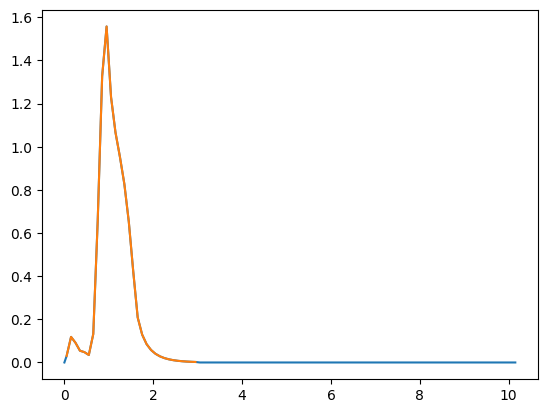

In [121]:
plt.plot(Plin['z'], new_matrix)
plt.plot(dndz['zrange'], dndz['dndz'].mean(axis=0))

In [63]:
np.diff(Plin['z'])

array([0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05,
       0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.05, 0.

In [68]:
tst = np.interp(Plin['z'], dndz['zrange'], dndz['dndz'].mean(axis=0),
          left = 0, right = 0)

(0.0, 1.6)

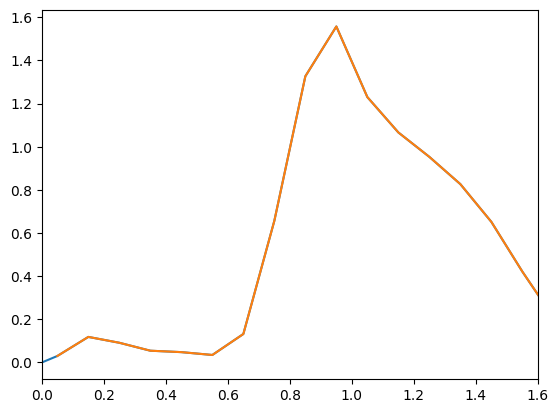

In [70]:
plt.plot(Plin['z'], tst)
plt.plot(dndz['zrange'], dndz['dndz'].mean(axis=0))
plt.xlim([0,1.6])

In [ ]:
plt.plot()

array([0.  , 0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95,
       1.05, 1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05,
       2.15, 2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95])

In [65]:
dndz['zrange']

array([0.05, 0.15, 0.25, 0.35, 0.45, 0.55, 0.65, 0.75, 0.85, 0.95, 1.05,
       1.15, 1.25, 1.35, 1.45, 1.55, 1.65, 1.75, 1.85, 1.95, 2.05, 2.15,
       2.25, 2.35, 2.45, 2.55, 2.65, 2.75, 2.85, 2.95])

In [66]:
Plin['z']

array([ 0.  ,  0.05,  0.1 ,  0.15,  0.2 ,  0.25,  0.3 ,  0.35,  0.4 ,
        0.45,  0.5 ,  0.55,  0.6 ,  0.65,  0.7 ,  0.75,  0.8 ,  0.85,
        0.9 ,  0.95,  1.  ,  1.05,  1.1 ,  1.15,  1.2 ,  1.25,  1.3 ,
        1.35,  1.4 ,  1.45,  1.5 ,  1.55,  1.6 ,  1.65,  1.7 ,  1.75,
        1.8 ,  1.85,  1.9 ,  1.95,  2.  ,  2.05,  2.1 ,  2.15,  2.2 ,
        2.25,  2.3 ,  2.35,  2.4 ,  2.45,  2.5 ,  2.55,  2.6 ,  2.65,
        2.7 ,  2.75,  2.8 ,  2.85,  2.9 ,  2.95,  3.  ,  3.05,  3.1 ,
        3.15,  3.2 ,  3.25,  3.3 ,  3.35,  3.4 ,  3.45,  3.5 ,  3.55,
        3.6 ,  3.65,  3.7 ,  3.75,  3.8 ,  3.85,  3.9 ,  3.95,  4.  ,
        4.05,  4.1 ,  4.15,  4.2 ,  4.25,  4.3 ,  4.35,  4.4 ,  4.45,
        4.5 ,  4.55,  4.6 ,  4.65,  4.7 ,  4.75,  4.8 ,  4.85,  4.9 ,
        4.95,  5.  ,  5.05,  5.1 ,  5.15,  5.2 ,  5.25,  5.3 ,  5.35,
        5.4 ,  5.45,  5.5 ,  5.55,  5.6 ,  5.65,  5.7 ,  5.75,  5.8 ,
        5.85,  5.9 ,  5.95,  6.  ,  6.05,  6.1 ,  6.15,  6.2 ,  6.25,
        6.3 ,  6.35,

In [61]:
Plin['z'].shape

(205,)

In [54]:
new_matrix[new_matrix > 0

15

In [55]:
dndz['zrange'].shape

(30,)

In [56]:
dndz['dndz'].mean(axis = 0)

array([0.0301039 , 0.1185164 , 0.09135664, 0.05454295, 0.04795344,
       0.0347682 , 0.13196637, 0.65681441, 1.32650456, 1.55739618,
       1.23017891, 1.0662644 , 0.95300988, 0.82665647, 0.65179378,
       0.42128632, 0.20873498, 0.1293551 , 0.08514541, 0.05797201,
       0.0403514 , 0.0285305 , 0.02041203, 0.01473959, 0.01072362,
       0.00785054, 0.00577756, 0.00427125, 0.00317014, 0.0023611 ])

In [2]:
import cib
import consts
#import precalculation as pc
import matplotlib.pyplot as plt
import numpy as np

/Users/tkarim/opt/anaconda3/envs/cosmo/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


In [65]:
import halo as h
import precalc as pc
import powerspectra as ps

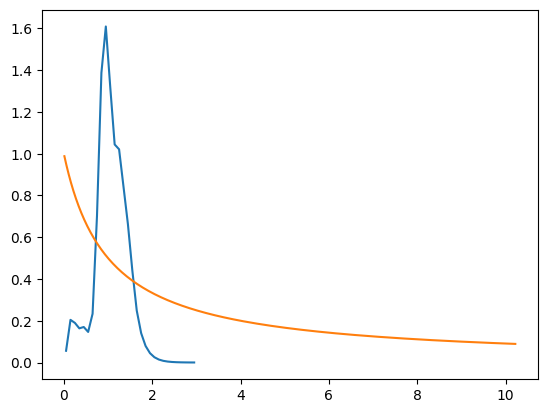

In [94]:
plt.plot(consts.dict_gal['ELG']['z'], ps.get_W_gal(1))
plt.plot(consts.redshifts_M23, pc.W_cib)

In [128]:
pc.halo_biases

array([[0.68821276, 0.70285002, 0.71933944, ..., 1.80957559, 1.88230014,
        1.95741236],
       [0.68821314, 0.70285042, 0.71933987, ..., 1.80957621, 1.88230077,
        1.95741299],
       [0.68821364, 0.70285094, 0.71934041, ..., 1.80957702, 1.88230158,
        1.95741381],
       ...,
       [0.86418302, 0.88962707, 0.9164973 , ..., 2.10819616, 2.18258097,
        2.25932211],
       [0.9041224 , 0.93275604, 0.96293466, ..., 2.1958882 , 2.27074151,
        2.34793373],
       [0.95062763, 0.98280736, 1.01671583, ..., 2.30930771, 2.38484348,
        2.46268205]])

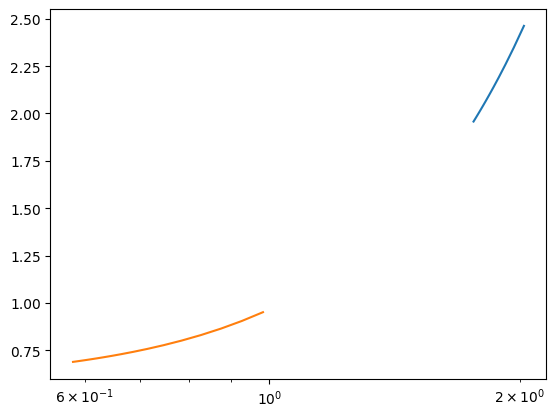

In [130]:
plt.semilogx(pc.nu200[:,-1], pc.halo_biases[:,-1])
plt.semilogx(pc.nu200[:,0], pc.halo_biases[:,0])

In [49]:
pc.dlnpk_dlnk.shape

(50, 30)

In [56]:
prof_params = np.array([0.58, 6.14, 0.67]) #fexp, tau, lambda_NFW

In [60]:
tst = h.uprof_mixed(prof_params = prof_params,
              rho_crit= consts.rho_crit_ELG,
              rad = pc.rad200,
              dlnpk_dlnk=pc.dlnpk_dlnk)

In [61]:
tst.shape

(400, 50, 30)

In [37]:
power.shape

(30, 400)

In [41]:
np.diff(power, axis = 1).shape

(30, 399)

In [42]:
denom = (np.log(kk[-1]) - np.log(kk[-2]))

In [45]:
num = (np.log(power[:,-1]) - np.log(power[:,-2]))

In [47]:
num/denom

array([-2.48538278, -2.48538147, -2.48538229, -2.48538201, -2.48538099,
       -2.48538069, -2.48538107, -2.48538114, -2.48538171, -2.48538153,
       -2.4853801 , -2.48537963, -2.48538117, -2.48538031, -2.48537986,
       -2.48538042, -2.4853792 , -2.48537991, -2.48537995, -2.48537986,
       -2.48538036, -2.4853796 , -2.48538011, -2.48538022, -2.48538113,
       -2.48537932, -2.48537977, -2.48538012, -2.48538083, -2.48538116])

In [176]:
from astropy.cosmology import Planck18 as planck
import astropy.units as u

In [180]:
z = consts.dict_gal['ELG']['z']
Mh = consts.Mh

In [184]:
rho_crit = (planck.critical_density(z)).to(u.Msun/u.Mpc**3)
rho_crit

<Quantity [1.33284779e+11, 1.47646838e+11, 1.64737575e+11, 1.84794418e+11,
           2.08054820e+11, 2.34756255e+11, 2.65136226e+11, 2.99432255e+11,
           3.37881893e+11, 3.80722712e+11, 4.28192310e+11, 4.80528310e+11,
           5.37968356e+11, 6.00750121e+11, 6.69111300e+11, 7.43289611e+11,
           8.23522798e+11, 9.10048631e+11, 1.00310490e+12, 1.10292943e+12,
           1.20976005e+12, 1.32383464e+12, 1.44539107e+12, 1.57466728e+12,
           1.71190120e+12, 1.85733079e+12, 2.01119404e+12, 2.17372896e+12,
           2.34517360e+12, 2.52576601e+12] solMass / Mpc3>

In [189]:
tst = 3 * (Mh[:, np.newaxis] * u.Msun)/(4 * np.pi * rho_crit[np.newaxis, :])
tst.shape

(50, 30)

In [191]:
(planck.Om0*planck.critical_density0).to(u.Msun/u.Mpc**3)

<Quantity 3.93431748e+10 solMass / Mpc3>

Develop $S_{\rm eff}$ for model `M23`

In [3]:
from astropy.io import fits
from scipy.interpolate import interp1d
import numpy as np
import consts

In [4]:
# import Abhi's prepared Planck file
snuaddr = 'data/filtered_snu_planck.fits'
hdulist = fits.open(snuaddr)

In [5]:
wavelengths = np.loadtxt('data/TXT_TABLES_2015/EffectiveSED_B15_z0.012.txt')[:, [0]]
redshifts = hdulist[1].data
snu_eff = hdulist[0].data[:-1, :]  # in Jy/Lsun  # -1 because we are
# not considering the 3000 GHz channel which comes from IRAS
hdulist.close()

In [6]:
snu_eff.shape

(6, 210)

In [7]:
redshifts.shape

(210,)

In [8]:
seff_interp_func = interp1d(redshifts, snu_eff, kind='linear',
                            bounds_error=False, fill_value=0.)

In [21]:
z = consts.dict_gal['ELG']['z']

In [23]:
seff_interp_func(z).shape

(6, 30)

In [167]:
tst3_int, tst3 = cib.Seff(params = (1.7, 24.4, 0.36), model = 'Y23')

1.2888578409581448
(6, 210)
(210,)
1.636061476332589e+24


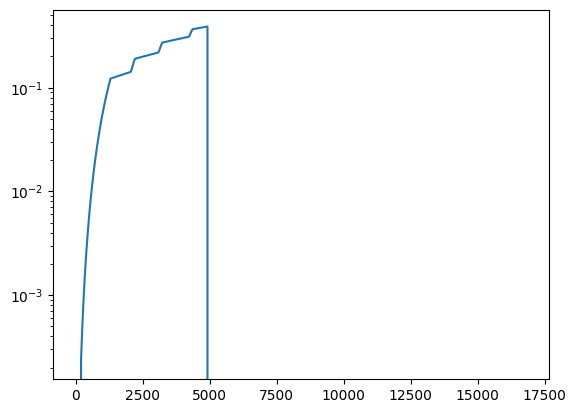

In [156]:
plt.semilogy(tst3_int[0])

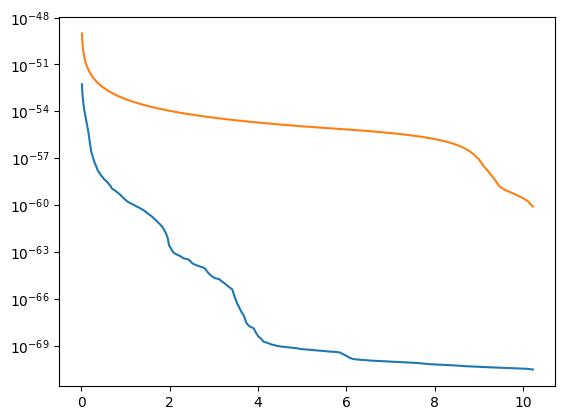

In [168]:
plt.semilogy(consts.redshifts_M23, tst3[0])
plt.semilogy(consts.redshifts_M23, tst3[-1])

In [170]:
consts.snu_eff_M23_ELG_z_bins/1e26

array([[7.65523362e-41, 8.79027211e-42, 3.39645567e-42, 1.86592719e-42,
        1.23863535e-42, 9.08139604e-43, 7.13800869e-43, 5.84251013e-43,
        5.01038771e-43, 4.40924413e-43, 3.94020568e-43, 3.58072222e-43,
        3.32708303e-43, 3.11592421e-43, 2.91031083e-43, 2.74531010e-43,
        2.63359713e-43, 2.53921358e-43, 2.43772204e-43, 2.33709160e-43,
        2.27356797e-43, 2.22482435e-43, 2.16057429e-43, 2.10140617e-43,
        2.07406362e-43, 2.03340786e-43, 1.99612875e-43, 1.97411053e-43,
        1.94125302e-43, 1.92814761e-43],
       [1.41284894e-40, 1.75324835e-41, 7.21855807e-42, 4.18345173e-42,
        2.90500473e-42, 2.20966151e-42, 1.78793700e-42, 1.50036871e-42,
        1.31499375e-42, 1.17775222e-42, 1.06713026e-42, 9.81537736e-43,
        9.21733324e-43, 8.70757982e-43, 8.18745883e-43, 7.76796295e-43,
        7.49176831e-43, 7.25616360e-43, 6.99143181e-43, 6.72796796e-43,
        6.56730987e-43, 6.44809416e-43, 6.28305147e-43, 6.13216634e-43,
        6.07107710e-43,

Convolve $S_{\rm eff}$ with Planck filters

In [34]:
from astropy.cosmology import Planck18 as planck
import astropy.units as u
from scipy import constants as spconst

In [41]:
from scipy.integrate import simpson
import matplotlib.pyplot as plt

In [42]:
planck_nu_list = consts.nu_list
ghz = consts.ghz
z_cib_planck = consts.redshifts_M23

In [43]:
# convolution function part 
seff_convolved = np.empty((len(planck_nu_list), len(z_cib_planck))) 

In [44]:
planck_nu_list = (planck_nu_list/ghz).astype(int)

In [45]:
filtfreq = {}
filter_response = {}

for i in range(len(planck_nu_list)):
    # read in filter curves
    filter_str_name = str(planck_nu_list[i])
    fname = f'data/filters/HFI__avg_{filter_str_name}_CMB_noise_avg_Apod5_Sfull_v302_HNETnorm.dat'
    filtarray = np.loadtxt(fname, usecols=(1,2))
    
    filter_response_curve = filtarray[:,1] # response curve 
    filtfreq[i] = filtarray[:,0] * ghz # convert to Hz 
    
    area = simpson(y=filter_response_curve, x=filtfreq[i]) # area under filter
    filter_response[i] = filter_response_curve/area # normalize by area

In [85]:
filter_response_curve

array([3.81460344e-07, 3.81468726e-07, 3.81493873e-07, ...,
       3.04315334e-17, 4.15348135e-17, 4.50687905e-17])

In [86]:
filter_response[i]

array([1.73139836e-18, 1.73143640e-18, 1.73155054e-18, ...,
       1.38124730e-28, 1.88521059e-28, 2.04561316e-28])

(50000000000.0, 2000000000000.0)

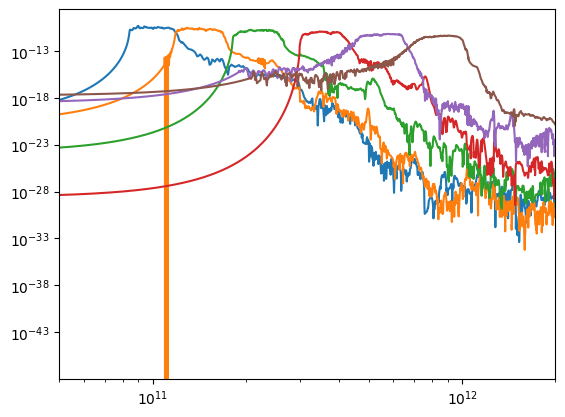

In [46]:
# this is from Planck

for k in filtfreq:
    plt.loglog(filtfreq[k], filter_response[k])
plt.xlim([5e10,2e12])

In [54]:
import cib

In [73]:
tst = cib.Seff(params = (1.7, 20000, 0.36), model = 'Y23')
tst.shape

(10000, 210)

In [115]:
tst_func = lambda z_idx: interp_slice(consts.nu_primes[:,z_idx[0]], 
                                               tst[:, z_idx[0]])

In [116]:
np.arange(consts.nu_primes.shape[1]).reshape(-1,1).shape

(210, 1)

In [117]:
tst_func(np.array([5]))

array([0., 0., 0., ..., 0., 0., 0.])

In [118]:
tst_interp = np.apply_along_axis(tst_func, axis = 1,
                    arr=
                    )

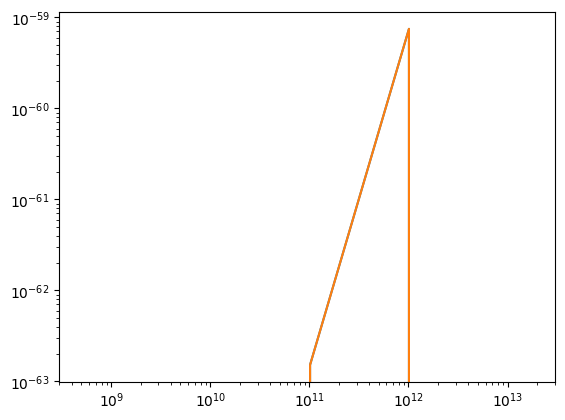

In [119]:
plt.loglog(filtfreq[0], 
           interp_slice(consts.nu_primes[:,0], tst[:,0]))
plt.loglog(filtfreq[0], tst_interp[0])

In [120]:
tst_interp.shape

(210, 12297)

In [121]:
filtfreq[0].shape

(12297,)

In [90]:
consts.nu_primes.shape

(10000, 210)

In [91]:
tst.shape

(10000, 210)

In [57]:
intsnu=np.interp(filtfreq[0], 
                 consts.nu_primes[:,0],
                 tst[:,0])

In [74]:
tnu_snu = filter_response[0] * intsnu # weight by filter response 
snu_eff15_filt = np.trapz(tnu_snu, filtfreq[0])

In [130]:
simpson(y= tst_interp, x=filtfreq[0],axis=1)

array([1.61710378e-48, 4.51844059e-49, 2.01726379e-49, 1.15621005e-49,
       7.58130795e-50, 5.29609185e-50, 4.01808720e-50, 3.17601652e-50,
       2.53871505e-50, 2.09664776e-50, 1.77840615e-50, 1.52376160e-50,
       1.33110144e-50, 1.16732468e-50, 1.04072219e-50, 9.37372922e-51,
       8.51960360e-51, 7.74654452e-51, 7.08074393e-51, 6.55363065e-51,
       6.06977173e-51, 5.70043667e-51, 5.33501976e-51, 5.01616721e-51,
       4.70208815e-51, 4.45767111e-51, 4.22686264e-51, 4.03435307e-51,
       3.86373466e-51, 3.67680489e-51, 3.54179330e-51, 3.40895708e-51,
       3.28157134e-51, 3.15652633e-51, 3.06239049e-51, 2.96245268e-51,
       2.87670514e-51, 2.79399393e-51, 2.71866292e-51, 2.64989551e-51,
       2.58699255e-51, 2.52628306e-51, 2.46375368e-51, 2.42004960e-51,
       2.37352011e-51, 2.32438550e-51, 2.28962518e-51, 2.25191061e-51,
       2.21144171e-51, 2.18568468e-51, 2.15525292e-51, 2.12746485e-51,
       2.10209372e-51, 2.07893447e-51, 2.05173269e-51, 2.03267249e-51,
      

In [124]:
tnu_snu.shape

(12297,)

In [65]:
consts.nu_primes[:,-1]/consts.ghz

array([ 1122.        ,  1123.00990099,  1124.01980198, ...,
       11217.98019802, 11218.99009901, 11220.        ])

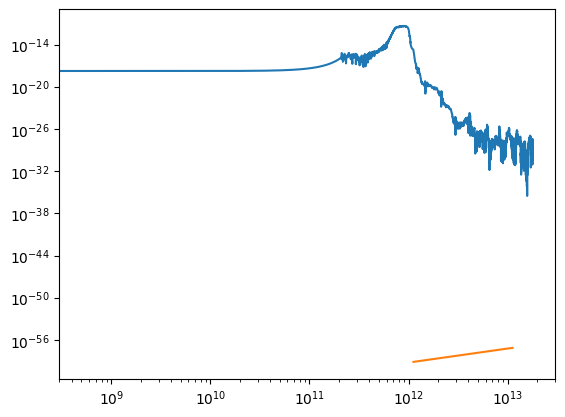

In [69]:
# plt.loglog(filtfreq[0], intsnu)
plt.loglog(filtfreq[5], filter_response[5])
plt.loglog(consts.nu_primes[:,-1],
                 tst[:,-1])

In [70]:
seff_m23 = consts.snu_eff_M23_ELG_z_bins

In [72]:
seff_m23[-1]

array([2.80495789e-12, 3.56598211e-13, 1.47542176e-13, 8.44541050e-14,
       5.70172355e-14, 4.17551155e-14, 3.23998576e-14, 2.59808442e-14,
       2.16517728e-14, 1.84690055e-14, 1.60316319e-14, 1.41274555e-14,
       1.26089967e-14, 1.12848013e-14, 1.00863120e-14, 9.06098958e-15,
       8.20635742e-15, 7.47314889e-15, 6.82241132e-15, 6.21874517e-15,
       5.71498132e-15, 5.29765804e-15, 4.90542079e-15, 4.54864697e-15,
       4.26197457e-15, 3.97500679e-15, 3.72571893e-15, 3.51076771e-15,
       3.28642177e-15, 3.11072880e-15])

Test `Theta`

In [43]:
nu_primes = consts.nu_primes
z = consts.dict_gal['ELG']['z']
beta = 1.7
T0 = 24.4
alpha = 0.36
dgamma = 1.7

In [26]:
theta = np.zeros_like(nu_primes) # shape (nu, z)
theta.shape

(6, 30)

Text(0, 0.5, 'Dust Temp')

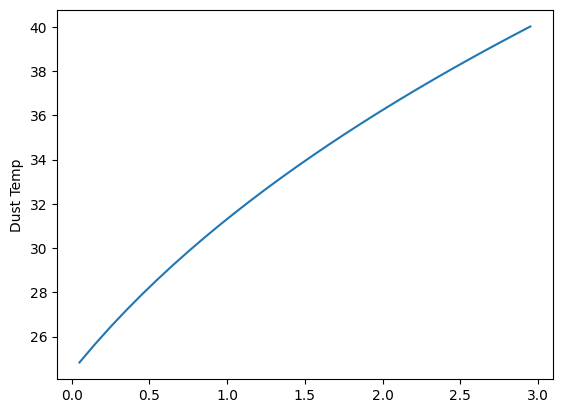

In [35]:
Td = cib.Tdust(T0, alpha)
plt.plot(z, Td)
plt.ylabel("Dust Temp")

Text(0, 0.5, 'Pivot frequency')

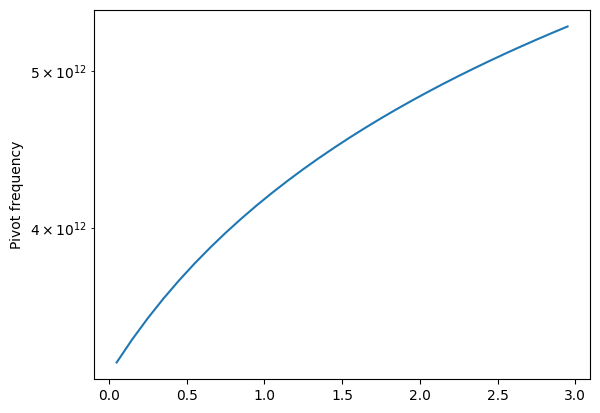

In [34]:
nu0z = cib.nu0_z(beta, Td)
plt.semilogy(z, nu0z)
plt.ylabel("Pivot frequency")

In [58]:
def prenu0(beta, Td, nu):
    """
    Returns the gray-body part of the SED.
    """
    
    res = nu**beta * cib.B_nu(nu, Td)
    
    return res 
    
def postnu0(gamma, nu):
    """
    Returns the exponential decay part of the SED.
    """
    
    res = nu**(-gamma)
    
    return res

In [56]:
flag = nu_primes < nu0z[np.newaxis, :]
flag.shape

(6, 30)

In [59]:
theta = np.where(flag, 
                     prenu0(beta, Td, nu_primes), 
                     postnu0(dgamma, nu_primes))

In [60]:
theta.shape

(6, 30)

In [62]:
tst = theta/(nu0z[np.newaxis, :]**beta * cib.B_nu(nu0z[np.newaxis, :], Td))

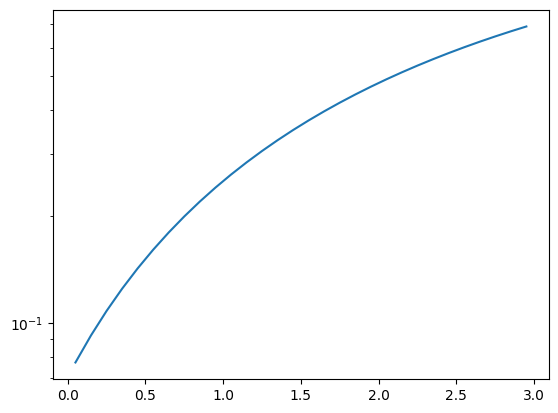

In [65]:
plt.semilogy(z, tst[4])

In [ ]:
theta/(nu0z[np.newaxis, :]**beta * cib.B_nu(nu0z[np.newaxis, :], Td))

In [69]:
tst = np.where(flag, 
         theta/prenu0(beta, Td, nu0z[np.newaxis, :]),
         theta/postnu0(dgamma, nu0z[np.newaxis, :]))

In [70]:
tst.shape

(6, 30)

In [72]:
tst.shape

(6, 30)

In [ ]:
def Theta(params):
    """
    Returns the modified SED for gray-body function 
    normalized to 1 at pivot freq.
    
    From 2.27 of 2310.10848.
    
    theta(nu') = nu'^beta * B_nu' (T) for n < nu0
               = nu'^(-gamma) for n >= nu0
    
    Args:
        params: (beta, T0, alpha)
            beta: controls "grayness" of blackbody function
            T0, alpha: dust parameters

    """
    
    beta, T0, alpha = params
    theta = np.zeros_like(nu_primes) # shape (nu, z)
    Td = Tdust(T0, alpha)
    nu0z = nu0_z(beta, Td)
    
    # decide which frequencies fall in the first category
    flag = nu_primes < nu0z[np.newaxis, :]
    
    # calculate SED
    theta[flag] = nu_primes[flag]**beta * B_nu(nu_primes[flag], Td)
    theta[~flag] = nu_primes[~flag]**(-dgamma)
    
    # normalize SED such that theta(nu0) = 1
    theta[flag] = theta[flag]/(nu0z[np.newaxis, :]**beta * B_nu(nu0z[np.newaxis, :], Td))
    theta[~flag] = theta[~flag]/nu0z[np.newaxis, :]**(-dgamma)
    
    return theta

In [3]:
ms = consts.ms

In [4]:
Mh = consts.Mh
Mhc = consts.Mhc

In [30]:
bar_sub = consts.BAR(ms, consts.dict_gal['ELG']['z'])

In [5]:
z = consts.dict_gal['ELG']['z']

In [6]:
Mhc_re = np.expand_dims(Mhc, axis = 0)
Mhc_re.shape

(1, 50)

In [7]:
tst = ms/Mhc_re

In [9]:
tst.shape

(100, 50)

In [10]:
etamax = 0.49
mu_peak0 = 11.51
mu_peakp = -0.02
sigma_M0 = 2.74
tau = 0.5
zc = 2.15

In [12]:
option1 = cib.SFR(etamax, mu_peak0, mu_peakp, 
                      sigma_M0, tau, zc,
                      is_sub = True)
option1.shape

(100, 50, 30)

In [45]:
tstsfr = cib.SFR(etamax, mu_peak0, mu_peakp, 
                                  sigma_M0, tau, zc,
                                  is_sub = True)
tstsfr.shape

(100, 50, 30)

In [46]:
tst_shmf = 0.3 * tst**(-0.7) * np.exp(-9.9 * tst**2.5)

In [47]:
tst_shmf.shape

(100, 50)

In [ ]:
        for i in range(len(self.mh)):
            ms = self.msub(self.mh[i]*(1-fsub))
            dlnmsub = np.log10(ms[1] / ms[0])
            sfrI = self.sfr(ms)  # dim(len(ms), len(z))
            sfrII = self.sfr(self.mh[i]*(1-fsub))*ms[:, None]/(self.mh[i]*(1-fsub))
            # sfrII = sfrmh[i] * ms / mh[i]
            sfrsub = np.zeros((len(ms), len(self.z)))
            for j in range(len(ms)):
                sfrsub[j, :] = np.minimum(sfrI[j, :], sfrII[j, :])
            integral = self.subhmf(self.mh[i], ms)[:, None]*sfrsub / KC
            intgn = intg.simps(integral, dx=dlnmsub, axis=0)
            a[:, i, :] = snu*(1 + self.z)*intgn *\
                self.cosmo.comoving_distance(self.z).value**2
        return a


In [77]:
idx = 13
l1 = tstsfr[:,idx,:]
l2 = np.log10(ms[:,idx][1]/ms[:,idx][0])
print(l1.shape)
print(l2)

(100, 30)
0.030908756278880567


In [82]:
l10 = l1 * tst_shmf[:,idx][:,None]
l10.shape

(100, 30)

In [83]:
l11 = simpson(l10, dx = l2, axis = 0)
l11.shape

(30,)

In [48]:
integrand = tstsfr * np.expand_dims(tst_shmf, 
                                    axis = -1)
integrand.shape

(100, 50, 30)

In [49]:
from scipy.integrate import simpson

In [66]:
res = simpson(y=integrand, 
              x=np.expand_dims(np.log10(ms), axis = -1),
              axis = 0)

In [89]:
Mh.shape

(50,)

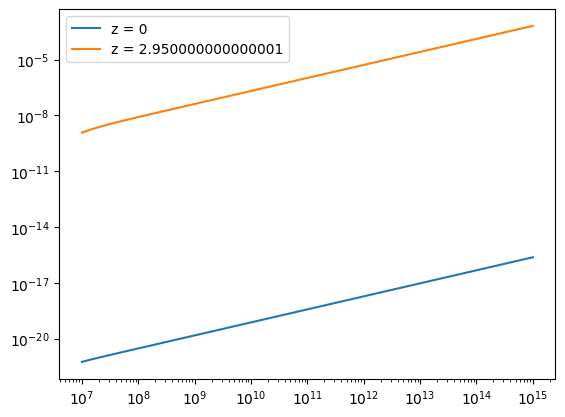

In [70]:
plt.loglog(Mh, res[:,0], label = 'z = 0')
plt.loglog(Mh, res[:,-1], label = f'z = {z[-1]}')
plt.legend(loc = 'best')

In [54]:
integrand.shape

(100, 50, 30)

In [56]:
np.log10(ms).shape

(100, 50)

In [65]:
np.log10(ms[:,10][11]/ms[:,10][10])

0.025961322760018352

Test `eta`

In [9]:
# eta
tst = cib.eta(0.49, 11.51, -0.02, 2.74, 0.5, 2.15)

In [11]:
tst.shape

(50, 30)

In [12]:
Mh = consts.Mh
etamax = 0.49
mu_peak0 = 11.51
mu_peakp = -0.02
sigma_M0 = 2.74
tau = 0.5
zc = 2.15

Text(0, 0.5, 'Mpeak')

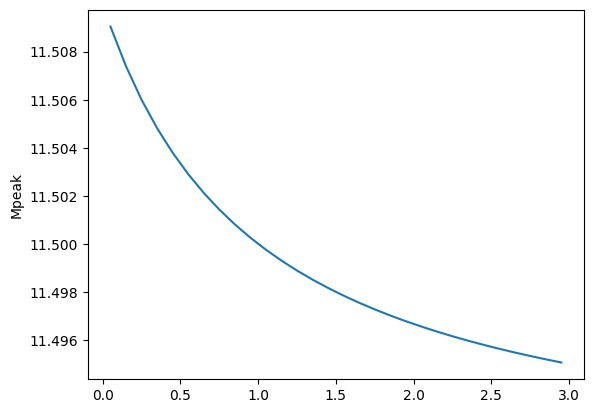

In [14]:
Mpeak = mu_peak0 + mu_peakp * z/(1+z) # M_peak may change with z 
plt.plot(z, Mpeak)
plt.ylabel("Mpeak")

Text(0, 0.5, 'sigmaM')

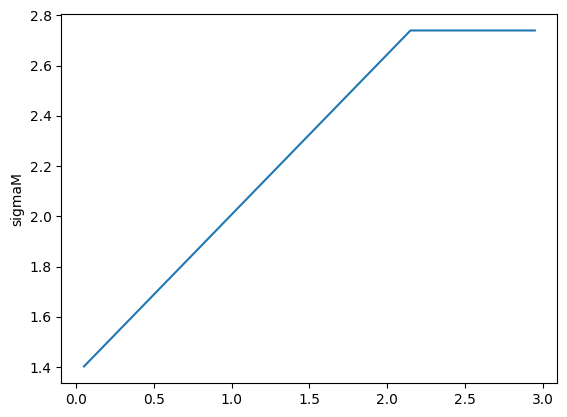

In [17]:
sigmaM = np.where(Mh[11] < Mpeak, sigma_M0, 
                  sigma_M0 * (1 - tau/zc * np.maximum(0, zc - z)))
plt.plot(z, sigmaM)
plt.ylabel("sigmaM")

Text(0, 0.5, 'eta')

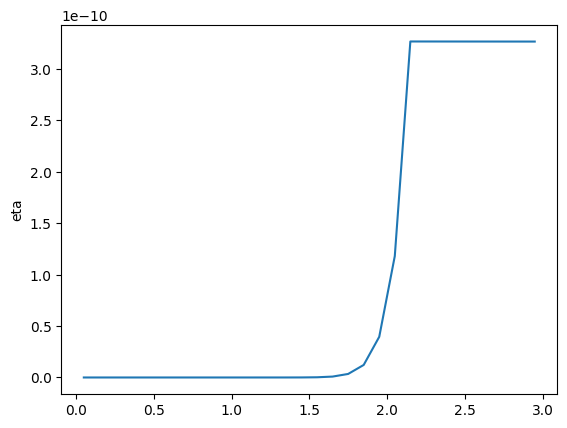

In [19]:
eta_val = etamax * np.exp(-0.5 * ((np.log(Mh[11]) - np.log(Mpeak))/sigmaM)**2)
plt.plot(z, eta_val)
plt.ylabel("eta")

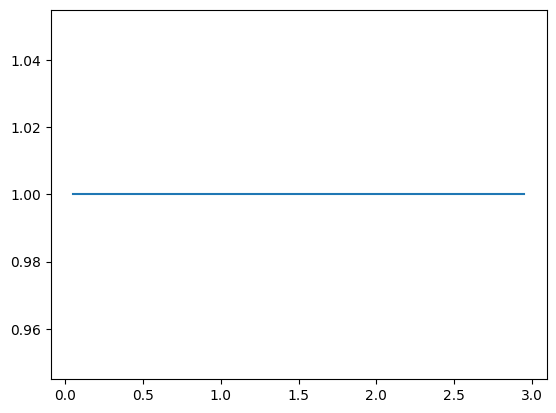

In [21]:
plt.plot(z, eta_val/tst[11])

In [22]:
eta_val/tst[11]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Test `SFR`

In [23]:
tst = cib.SFR(0.49, 11.51, -0.02, 2.74, 0.5, 2.15)

In [24]:
tst.shape

(50, 30)

In [26]:
bar = consts.bar
bar.shape

(50, 30)

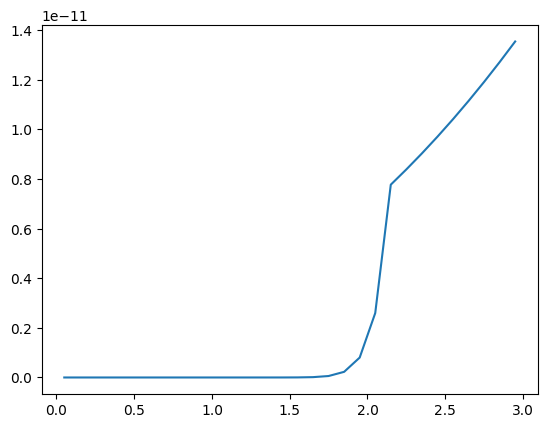

In [28]:
tst_manual = bar[11] * eta_val
plt.plot(z, tst_manual)

In [29]:
tst_manual/tst[11]

array([1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.,
       1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1., 1.])

Test `SFR`

In [91]:
tst = cib.SFR(etamax, mu_peak0, mu_peakp,
          sigma_M0, tau, zc, is_sub=False)

In [92]:
tst.shape

(50, 30)

In [13]:
bar = pc.bar

In [15]:
bar.shape

(50, 30)

In [18]:
np.maximum(5, 2)

5

In [45]:
# Sigma
tst = cib.Sigma(1.81, 12.25, 0.55)

In [46]:
sigma_M0 = 1.81
mu_peak0 = 12.25
mu_peakp = 0.55

M_peak = mu_peak0 + mu_peakp * z/(1+z) # M_peak may change with z 

In [47]:
prefact = consts.Mh[13]/np.sqrt(2 * np.pi * sigma_M0**2)

In [48]:
prefact * np.exp(expterm) - tst[13]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])

Test passed. 

In [21]:
# Sigma satellite
tst = cib.Sigmas(1.81, 12.25, 0.55)

Text(0.5, 0, 'z')

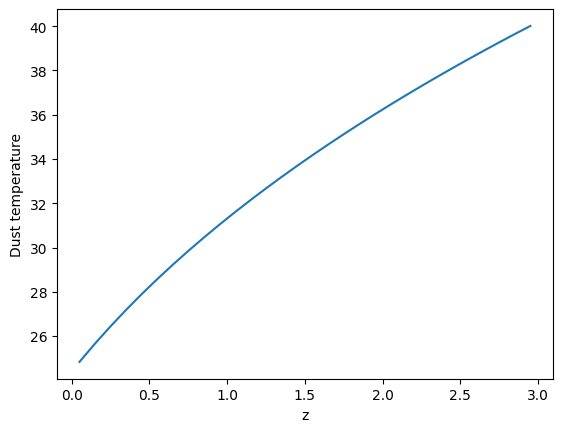

In [5]:
# dust temperature 
Td = cib.Tdust(z)
plt.plot(z, Td)
plt.ylabel("Dust temperature")
plt.xlabel("z")

In [6]:
#nu_list = np.array([100, 143, 217, 353, 545, 857, 3000]) * 1e9  
nu_list = np.logspace(7,15,1000)

In [7]:
# planck function (nu, z)
Bnu_all = cib.B_nu(nu_list, Td)

/Users/tkarim/Documents/research/cib.nosync/cib.py:63: RuntimeWarning: overflow encountered in exp
  res = prefact[:,np.newaxis]/(np.exp(x) - 1)


(1e-24, 1e-11)

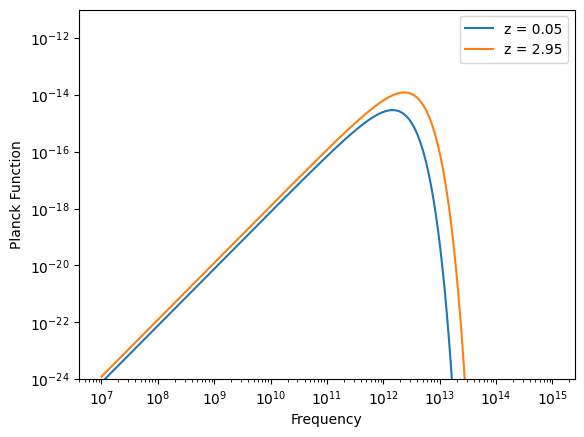

In [8]:
plt.loglog(nu_list, Bnu_all.T[0], label = f'z = {z[0]}')
plt.loglog(nu_list, Bnu_all.T[-1], label = f'z = {np.round(z[-1],2)}')
plt.legend(loc = 'best')
plt.xlabel("Frequency")
plt.ylabel("Planck Function")
plt.ylim([10e-25, 10e-12])

In [9]:
# modified planck function 
mod_Bnu_all = cib.mod_blackbody(Bnu_all, nu_list)

(1e-24, 1000000000000000.0)

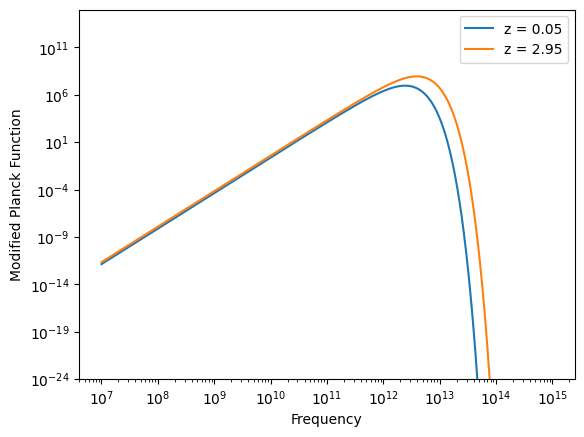

In [11]:
plt.loglog(nu_list, mod_Bnu_all.T[0], label = f'z = {z[0]}')
plt.loglog(nu_list, mod_Bnu_all.T[-1], label = f'z = {np.round(z[-1],2)}')
plt.legend(loc = 'best')
plt.xlabel("Frequency")
plt.ylabel("Modified Planck Function")
plt.ylim([10e-25, 10e14])

In [12]:
# pivot frequencies
tmpnu0 = cib.nu0_z(Td)

(1e-24, 10000000000000.0)

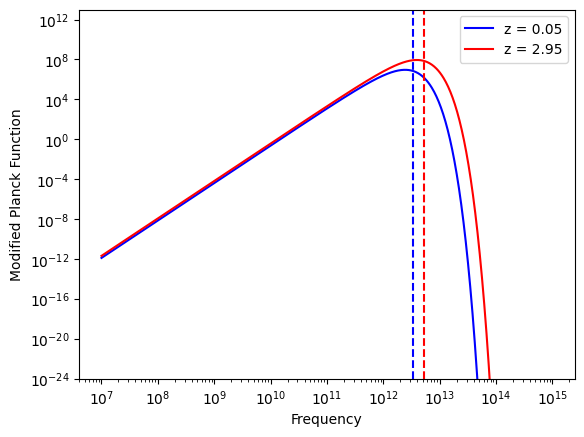

In [13]:
plt.loglog(nu_list, mod_Bnu_all.T[0], label = f'z = {z[0]}', c = 'b')
plt.axvline(tmpnu0[0], ls = '--', c = 'b')
plt.loglog(nu_list, mod_Bnu_all.T[-1], label = f'z = {np.round(z[-1],2)}', c = 'r')
plt.axvline(tmpnu0[-1], ls = '--', c = 'r')
plt.legend(loc = 'best')
plt.xlabel("Frequency")
plt.ylabel("Modified Planck Function")
plt.ylim([10e-25, 10e12])

In [14]:
tmpbnu = np.diag(cib.B_nu(tmpnu0, Td))

In [15]:
tmpbnu

array([8.72459118e-16, 9.62530079e-16, 1.05323057e-15, 1.14451401e-15,
       1.23634047e-15, 1.32867535e-15, 1.42148834e-15, 1.51475270e-15,
       1.60844461e-15, 1.70254274e-15, 1.79702787e-15, 1.89188258e-15,
       1.98709103e-15, 2.08263870e-15, 2.17851229e-15, 2.27469953e-15,
       2.37118908e-15, 2.46797043e-15, 2.56503380e-15, 2.66237005e-15,
       2.75997068e-15, 2.85782770e-15, 2.95593359e-15, 3.05428131e-15,
       3.15286420e-15, 3.25167599e-15, 3.35071073e-15, 3.44996280e-15,
       3.54942685e-15, 3.64909782e-15])

In [16]:
tmp_modbnu = np.diag(cib.mod_blackbody(tmpbnu, tmpnu0))

In [18]:
# theta
tmp_theta = cib.Theta(mod_Bnu_all, tmp_modbnu)

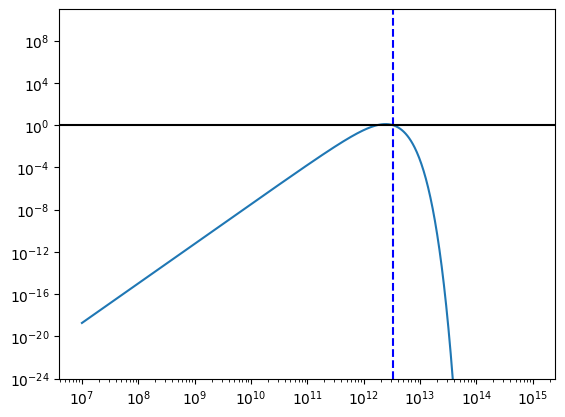

In [20]:
plt.loglog(nu_list, tmp_theta.T[0])
plt.ylim([10e-25, 10e10])
plt.axvline(tmpnu0[0], ls = '--', c = 'b')
plt.axhline(1, c = 'k')

In [23]:
tstt = mod_Bnu_all/tmp_modbnu
tstt.shape

(1000, 30)

In [26]:
tmpnu0

array([3.33204508e+12, 3.44297559e+12, 3.54789147e+12, 3.64756364e+12,
       3.74261542e+12, 3.83355883e+12, 3.92082033e+12, 4.00475930e+12,
       4.08568183e+12, 4.16385101e+12, 4.23949484e+12, 4.31281239e+12,
       4.38397862e+12, 4.45314823e+12, 4.52045876e+12, 4.58603311e+12,
       4.64998162e+12, 4.71240373e+12, 4.77338947e+12, 4.83302061e+12,
       4.89137167e+12, 4.94851078e+12, 5.00450043e+12, 5.05939808e+12,
       5.11325669e+12, 5.16612522e+12, 5.21804899e+12, 5.26907011e+12,
       5.31922773e+12, 5.36855833e+12])

In [41]:
mod_Bnu_all.T.shape

(30, 1000)

In [42]:
from copy import deepcopy
tst2 = deepcopy(mod_Bnu_all.T[0])
tst2.shape

(1000,)

In [43]:
tst2[nu_list >= tmpnu0[0]] = nu_list[nu_list >= tmpnu0[0]]**(-1 * 1.7)

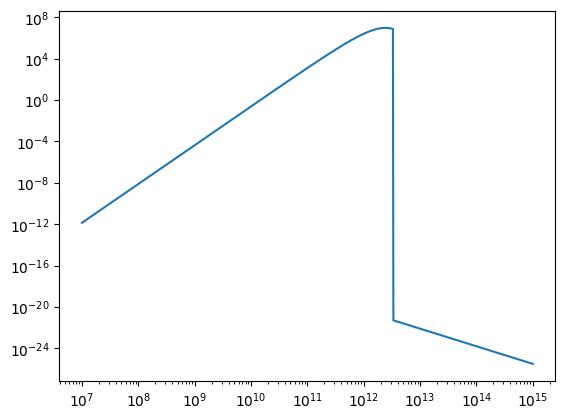

In [44]:
plt.loglog(nu_list, tst2)

In [49]:
nu_list[nu_list >= tmpnu0[0]]**(-1.7)

array([5.08869717e-22, 4.93165847e-22, 4.77946603e-22, 4.63197030e-22,
       4.48902632e-22, 4.35049364e-22, 4.21623612e-22, 4.08612183e-22,
       3.96002290e-22, 3.83781543e-22, 3.71937931e-22, 3.60459816e-22,
       3.49335920e-22, 3.38555310e-22, 3.28107393e-22, 3.17981902e-22,
       3.08168886e-22, 2.98658703e-22, 2.89442007e-22, 2.80509741e-22,
       2.71853128e-22, 2.63463660e-22, 2.55333094e-22, 2.47453439e-22,
       2.39816953e-22, 2.32416130e-22, 2.25243700e-22, 2.18292613e-22,
       2.11556038e-22, 2.05027356e-22, 1.98700151e-22, 1.92568206e-22,
       1.86625494e-22, 1.80866176e-22, 1.75284593e-22, 1.69875258e-22,
       1.64632858e-22, 1.59552239e-22, 1.54628410e-22, 1.49856531e-22,
       1.45231914e-22, 1.40750015e-22, 1.36406427e-22, 1.32196885e-22,
       1.28117250e-22, 1.24163514e-22, 1.20331791e-22, 1.16618316e-22,
       1.13019441e-22, 1.09531627e-22, 1.06151449e-22, 1.02875584e-22,
       9.97008128e-23, 9.66240162e-23, 9.36421705e-23, 9.07523454e-23,
      

In [31]:
tstt.shape

(1000, 30)

In [64]:
from astropy.io import fits

In [88]:
hdu = fits.open("data/filtered_snu_planck.fits")
wavelengths = np.loadtxt('data/TXT_TABLES_2015/EffectiveSED_B15_z0.012.txt')[:, [0]]

In [73]:
hdu[0].data

array([[1.26552135e-13, 3.47169099e-14, 1.51488574e-14, ...,
        5.57081231e-17, 5.65057599e-17, 5.75917015e-17],
       [2.26060663e-13, 6.26579312e-14, 2.76262871e-14, ...,
        1.41497839e-16, 1.42573896e-16, 1.44361516e-16],
       [7.30234004e-13, 2.03957385e-13, 9.05777273e-14, ...,
        3.34219674e-16, 3.32484995e-16, 3.31770905e-16],
       ...,
       [1.24239228e-11, 3.47058399e-12, 1.54154448e-12, ...,
        3.45019143e-16, 3.32928027e-16, 3.22691994e-16],
       [4.41938982e-11, 1.23156925e-11, 5.45570863e-12, ...,
        1.24409126e-16, 1.16572211e-16, 1.09734988e-16],
       [2.14144690e-10, 5.75534734e-11, 2.45899325e-11, ...,
        9.38288598e-18, 9.46975216e-18, 9.09417234e-18]])

In [76]:
redshifts = hdu[1].data
snu_eff = hdu[0].data  # in Jy/Lsun

In [77]:
redshifts.shape

(210,)

In [78]:
snu_eff.shape

(7, 210)

In [81]:
snu_eff.T[0]

array([1.26552135e-13, 2.26060663e-13, 7.30234004e-13, 3.27709454e-12,
       1.24239228e-11, 4.41938982e-11, 2.14144690e-10])

In [86]:
hdu[2].data

array([3.13921105e+10, 3.28716196e+10, 3.44208030e+10, 3.60430144e+10,
       3.77416455e+10, 3.95203728e+10, 4.13828769e+10, 4.33331924e+10,
       4.53754555e+10, 4.75139285e+10, 4.97531296e+10, 5.20979525e+10,
       5.45532468e+10, 5.71243253e+10, 5.98164873e+10, 6.26355343e+10,
       6.55874707e+10, 6.86784581e+10, 7.19152679e+10, 7.53044930e+10,
       7.88535328e+10, 8.25697117e+10, 8.64610520e+10, 9.05359081e+10,
       9.48026291e+10, 9.92706694e+10, 1.03949147e+11, 1.08848011e+11,
       1.13977827e+11, 1.19349358e+11, 1.24974449e+11, 1.30864020e+11,
       1.37031694e+11, 1.43489426e+11, 1.50252327e+11, 1.57333378e+11,
       1.64748287e+11, 1.72512636e+11, 1.80642483e+11, 1.89156634e+11,
       1.98071076e+11, 2.07405674e+11, 2.17181108e+11, 2.27415273e+11,
       2.38132746e+11, 2.49357425e+11, 2.61109139e+11, 2.73413521e+11,
       2.86299178e+11, 2.99792458e+11, 3.13921105e+11, 3.28715836e+11,
       3.44208030e+11, 3.60430144e+11, 3.77416455e+11, 3.95203728e+11,
      

In [90]:
nu0min = 50.  # nucen-deltanu/2.
nu0max = 3000.  # nucen+deltanu/2.
steps = 20  # 2000 nu0max-nu0min+1  # nu0max-nu0min+1  # 200
nu0 = np.linspace(nu0min, nu0max, int(steps))

In [83]:
import glob

In [84]:
list_of_files = sorted(glob.glob('./data/TXT_TABLES_2015/./*.txt'))

In [91]:
for i in range(len(list_of_files)):
    print(list_of_files[i][-9:-4])

0.012
0.023
0.035
0.047
0.059
0.072
0.084
0.096
0.109
0.122
0.135
0.148
0.161
0.175
0.189
0.202
0.216
0.230
0.245
0.259
0.274
0.288
0.303
0.318
0.334
0.349
0.365
0.380
0.396
0.413
0.429
0.445
0.462
0.479
0.496
0.514
0.531
0.549
0.567
0.585
0.603
0.622
0.641
0.660
0.679
0.698
0.718
0.738
0.758
0.778
0.799
0.820
0.841
0.862
0.884
0.905
0.928
0.950
0.972
0.995
1.018
1.042
1.065
1.089
1.113
1.138
1.163
1.188
1.213
1.239
1.265
1.291
1.317
1.344
1.371
1.399
1.427
1.455
1.483
1.512
1.541
1.570
1.600
1.630
1.661
1.692
1.723
1.754
1.786
1.818
1.851
1.884
1.917
1.951
1.985
0.092
0.220
2.020
2.055
2.090
2.126
2.162
2.199
2.236
2.273
2.311
2.350
2.388
2.428
2.467
2.508
2.548
2.589
2.631
2.673
2.715
2.758
2.802
2.846
2.890
2.936
2.981
3.027
3.074
3.121
3.169
3.217
3.266
3.315
3.365
3.416
3.467
3.519
3.571
3.624
3.677
3.732
3.786
3.842
3.898
3.955
4.012
4.070
4.129
4.188
4.248
4.309
4.370
4.433
4.495
4.559
4.623
4.689
4.754
4.821
4.888
4.957
5.026
5.095
5.166
5.237
5.310
5.383
5.457
5.531
5.607
5.68

In [30]:
a = list_of_files[95] #FIXME: why 95 and 96
b = list_of_files[96]

for i in range(95, 208): #FIXME: why this range 
    list_of_files[i] = list_of_files[i+2]
list_of_files[208] = a
list_of_files[209] = b

In [32]:
wavelengths = np.loadtxt('./data/TXT_TABLES_2015/EffectiveSED_B15_z0.012.txt')[:, [0]]

In [34]:
freq = 300000/wavelengths # in km/s

In [36]:
numerical_fac = 1.
freqhz = freq*1e3*1e6
freq *= numerical_fac

In [38]:
np.size(wavelengths)

200

In [41]:
len(wavelengths)

200

In [48]:
dndz = pd.read_csv("data/gal/elg_fuji_pz_single_tomo.csv")
z = dndz['Redshift_mid'].values

freq_rest = freqhz*(1 + z)

In [65]:
n = len(wavelengths) # number of wavelength bins 
n

200

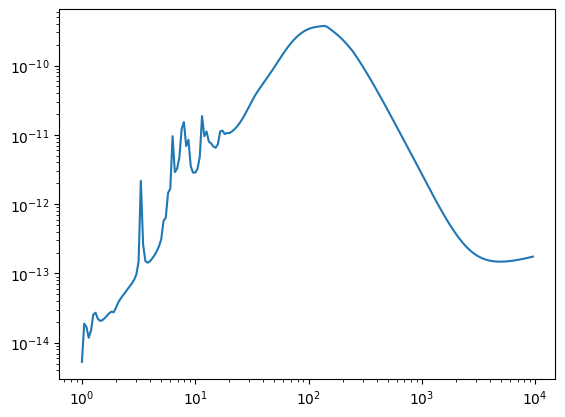

In [80]:
tmp = np.loadtxt(list_of_files[0])
plt.loglog(tmp[:,0], tmp[:,1])

In [66]:
snu_unfiltered = np.zeros([n, len(z)])

for i in range(len(list_of_files)):
    snu_unfiltered[:, i] = np.loadtxt(list_of_files[i])[:, 1]

IndexError: index 30 is out of bounds for axis 1 with size 30

In [72]:
len(list_of_files)

210

In [82]:
import consts

In [4]:
import numpy as np
import gal_prop as gp
import precalculation as pc
import consts
import matplotlib.pyplot as plt

/Users/tkarim/Documents/research/cib.nosync/gal_prop.py:84: RuntimeWarning: invalid value encountered in power
  return As * power_term**alpha


In [7]:
z = consts.dict_gal['ELG']['z']

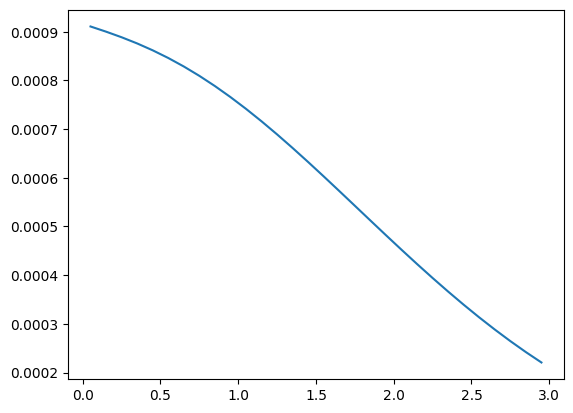

In [8]:
plt.plot(z, pc.nbar_gal)

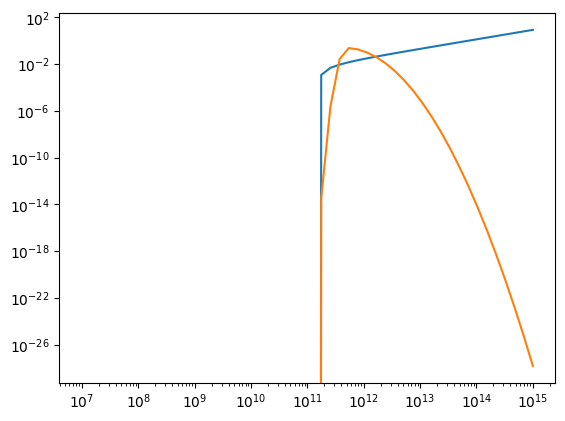

In [9]:
plt.plot(pc.Mh, pc.Nsat)
plt.plot(pc.Mh, pc.Ncen)
plt.xscale("log")
plt.yscale("log")

/Users/tkarim/Documents/research/cib.nosync/gal_prop.py:83: RuntimeWarning: invalid value encountered in power
  return As * power_term**alpha


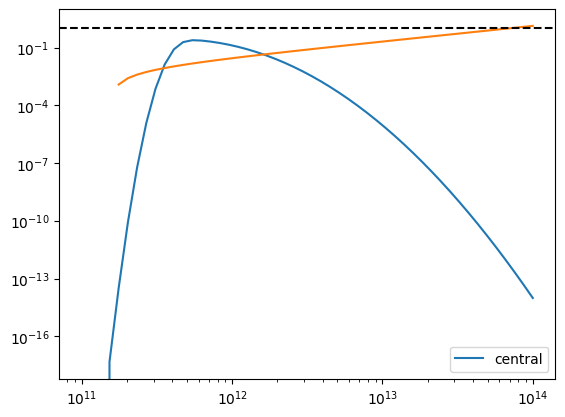

In [52]:
plt.plot(Mh, gp.Ncen(Mh), label = 'central')
plt.plot(Mh, gp.Nsat(Mh))
plt.legend(loc = 'best')
plt.xscale("log")
plt.yscale("log")
plt.axhline(1, c = 'k', ls = '--')

In [28]:
np.log10(Mh) - 11.83

array([-1.83      , -1.74836735, -1.66673469, -1.58510204, -1.50346939,
       -1.42183673, -1.34020408, -1.25857143, -1.17693878, -1.09530612,
       -1.01367347, -0.93204082, -0.85040816, -0.76877551, -0.68714286,
       -0.6055102 , -0.52387755, -0.4422449 , -0.36061224, -0.27897959,
       -0.19734694, -0.11571429, -0.03408163,  0.04755102,  0.12918367,
        0.21081633,  0.29244898,  0.37408163,  0.45571429,  0.53734694,
        0.61897959,  0.70061224,  0.7822449 ,  0.86387755,  0.9455102 ,
        1.02714286,  1.10877551,  1.19040816,  1.27204082,  1.35367347,
        1.43530612,  1.51693878,  1.59857143,  1.68020408,  1.76183673,
        1.84346939,  1.92510204,  2.00673469,  2.08836735,  2.17      ])

In [29]:
import scipy.special as ss

In [54]:
from colossus.lss import mass_function

In [56]:
from colossus.cosmology import cosmology as cc

In [58]:
cc.setCosmology('planck18')

In [71]:
hmf = mass_function.massFunction(Mh,
                           ,
                           q_in='M',
                           q_out='dndlnM',
                           model='tinker08',
                           mdef='200m')

TypeError: unsupported operand type(s) for +: 'float' and 'list'

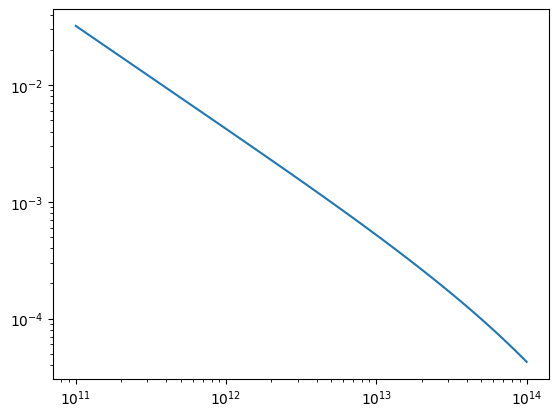

In [70]:
plt.loglog(Mh, hmf)